In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal
import neurokit2 as nk
import mne
from params import *
from bibliotheque import *
%matplotlib inline
# %matplotlib widget

## SAVE ?

In [25]:
save = True 
# save = False

## TOOLS

Preprocessing = 
* down sampling / 4 from 1000 to 250 Hz (enough to see until 125Hz), for less memory and faster computing
* bio = neurokit
* neuro = line noise removing + high pass 0.1 Hz

In [26]:
def preprocessing(sig, dtype, srate, participant):
    if dtype == 'ECG':
        clean = nk.ecg_clean(sig, sampling_rate=srate) 
        reverse = ecg_reverse[participant]
        if reverse == 1: # reverse if I have visually found than ecg have to be reversed to get peaks pointing up = better for peak finding by neurokit
            clean = -clean
    elif dtype == 'EDA':
        clean = nk.eda_clean(sig, sampling_rate=srate)
    elif dtype == 'PPG':
        clean = nk.ppg_clean(sig, sampling_rate=srate)
    elif dtype == 'EEGL' or dtype == 'EEGR':
        clean = mne.filter.notch_filter(sig, srate, freqs=np.arange(50,101,50), verbose = False) # notch filter to remove line_noise
        clean = mne.filter.filter_data(clean, srate, l_freq = 0.1, h_freq = None, verbose = False) # remove slow drift with high pass 0.1         
    return clean

## GO

###  - CUT AND CLEAN DATA

In [27]:
df_times = pd.read_excel('../data/df_timestamps.xlsx', index_col=0).set_index(['participant','room'])
df_times

start  stop  duration  start date  stop date  \
participant room                                                             
P06PHERAX   Baseline              0   223       223       41084      41307   
            Take-off            542   718       176       41626      41802   
            Savannah            719   798        79       41803      41882   
            Canopy              808  1207       399       41892      42291   
            Bats               1217  1422       205       42301      42506   
...                             ...   ...       ...         ...        ...   
P18BLAMA    Bats               1067  1136        69       41848      41917   
            Underground        1189  1238        49       41970      42019   
            Grassland          1241  1602       361       42022      42383   
            Sea                1605  1835       230       42386      42616   
            End of the world   1853  2372       519       42634      43153   

                             start datetime stop datetime  
participant room                                           
P06PHERAX   Baseline               11:24:44      11:28:27  
            Take-off               11:33:46      11:36:42  
            Savannah               11:36:43      11:38:02  
            Canopy                 11:38:12      11:44:51  
            Bats                   11:45:01      11:48:26  
...                                     ...           ...  
P18BLAMA    Bats                   11:37:28      11:38:37  
            Underground            11:39:30      11:40:19  
            Grassland              11:40:22      11:46:23  
            Sea                    11:46:26      11:50:16  
            End of the world       11:50:34      11:59:13  

[252 rows x 7 columns]

In [28]:
df_times.loc[('P01PPILNI','End of the world'),:]

start                 3815
stop                  4529
duration               714
start date           37787
stop date            38501
start datetime    10:29:47
stop datetime     10:41:41
Name: (P01PPILNI, End of the world), dtype: object

In [29]:
participants

['P01PPILNI',
 'P03PBABCO',
 'P07GHOLE',
 'P08AKKOR',
 'P10LEVVA',
 'P11KERSA',
 'P12BOULI',
 'P15LEPMA',
 'P16MAUAD',
 'P17ETRPA',
 'P21LIYAT',
 'P25PEIAN',
 'P27OSTMA',
 'P28JUDGU',
 'P30BATDI']

In [30]:
da_cleaned = None

for participant in participants:
    print(participant)
    da_raw = xr.load_dataarray(f'../data_in_da/da_{participant}.nc') # load da of the participant
    data_duration = int(da_raw.coords['time'][-1].values) # get recording duration of the participant
    for room in rooms:
        # print(room)
        start = df_times.loc[(participant,room),'start'] # get starting room timestamps in secs after beginning of recording
        stop = start + sig_by_room_duration # stop = start + defined duration of computing
        if start > data_duration:
            print(participant , 'WARNING : Recording shorter than timestamping')
        else:
            for dtype in dtypes:
                sig = da_raw.loc[dtype,start:stop].values # sel and cut

                down_sig = down_sample(sig, factor=4) # down sample for less memory and faster computing
                down_srate = srate / 4 # new srate = 250 Hz

                down_clean = preprocessing(down_sig, dtype, srate=down_srate, participant=participant) # apply preproc according to dtype

                if da_cleaned is None:
                    da_cleaned = init_da({'participant':participants, 'room':rooms, 'dtype':dtypes, 'cleaning':['raw','clean'], 'time':time_vector(down_clean, srate=down_srate)}) # initialize a data array with good shape (5 dims)

                da_cleaned.loc[participant, room, dtype,'raw',:] = down_sig # keep sig before preproc
                da_cleaned.loc[participant, room, dtype,'clean',:] = down_clean # get sig after preproc

if save:
    da_cleaned.to_netcdf('../data_preprocessed/da_cleaned.nc') # save


P01PPILNI
P03PBABCO
P03PBABCO WARNING : Recording shorter than timestamping
P07GHOLE
P08AKKOR
P10LEVVA
P11KERSA
P12BOULI
P12BOULI WARNING : Recording shorter than timestamping
P15LEPMA
P16MAUAD
P17ETRPA
P21LIYAT
P25PEIAN
P27OSTMA
P28JUDGU
P30BATDI


## **GLOBAL VIEWER** :

In [31]:
save_quality_df = True

rows = []

for dtype in dtypes:    
    for participant in all_participants:
        rows.append([dtype, participant , 0])
quality_df_encoder = pd.DataFrame(rows, columns = ['dtype','participant','quality'])
if save_quality_df:
    quality_df_encoder.to_excel('../data_preprocessed/quality_encoding_2.xlsx')

In [32]:
da_cleaned

<xarray.DataArray (participant: 15, room: 9, dtype: 5, cleaning: 2, time: 22501)>
array([[[[[ 1.00233514e+03,  1.00348723e+03,  9.89928313e+02, ...,
            4.64063170e+02,  4.18091773e+02,  4.27452921e+02],
          [ 2.84217094e-14,  1.08895065e+01, -3.37755401e+00, ...,
            3.41684774e+01, -8.50098734e+00, -5.32907052e-14]],

         [[ 4.45182009e+02,  4.91580667e+02,  4.72390902e+02, ...,
            6.57118525e+02,  5.73580759e+02,  6.54960896e+02],
          [ 0.00000000e+00,  3.05753679e+01,  1.67270879e+01, ...,
            8.46988848e-01, -8.02165826e+01, -7.10542736e-14]],

         [[ 5.13086713e+02,  5.14239300e+02,  5.12393733e+02, ...,
            5.32501656e+02,  5.31620439e+02,  5.24157627e+02],
          [-3.99481870e+00, -3.23349538e+00, -2.40230460e+00, ...,
            9.78090929e+00,  5.59578507e+00,  3.78464397e+00]],

         [[ 1.35434594e+02,  1.35405881e+02,  1.35642470e+02, ...,
            8.00720468e+01,  8.00731271e+01,  8.00728984e+01],
          [ 1.35440469e+02,  1.35449113e+02,  1.35457694e+02, ...,
            8.01139701e+01,  8.01139069e+01,  8.01138556e+01]],

...

         [[ 5.22322543e+02,  5.36033373e+02,  4.84471119e+02, ...,
            4.86773678e+02,  4.42402939e+02,  4.27822562e+02],
          [ 5.68434189e-14,  1.96192618e+01, -3.26953602e+01, ...,
            5.98148218e+01,  1.32349406e+01,  1.42108547e-14]],

         [[ 5.12021931e+02,  5.13100286e+02,  5.13369195e+02, ...,
            5.09764861e+02,  5.10276184e+02,  5.12051941e+02],
          [ 4.02698987e+00,  4.61290739e+00,  5.14984887e+00, ...,
            9.92205147e+00,  1.17204462e+01,  1.35628190e+01]],

         [[ 1.14673535e+02,  1.15373660e+02,  1.15364801e+02, ...,
            1.19615897e+02,  1.19614083e+02,  1.19615421e+02],
          [ 1.14702888e+02,  1.14728799e+02,  1.14754523e+02, ...,
            1.19601624e+02,  1.19601607e+02,  1.19601594e+02]],

         [[ 2.57088017e+01,  2.57077225e+01,  2.56550803e+01, ...,
            2.66900401e+01,  2.66990748e+01,  2.66871430e+01],
          [-6.26258120e+00, -3.50812536e+00, -9.25309278e-01, ...,
            3.03212115e+00,  1.15212188e+00, -8.81779910e-01]]]]])
Coordinates:
  * participant  (participant) <U9 'P01PPILNI' 'P03PBABCO' ... 'P30BATDI'
  * room         (room) <U16 'Baseline' 'Take-off' ... 'Sea' 'End of the world'
  * dtype        (dtype) <U4 'EEGL' 'EEGR' 'ECG' 'EDA' 'PPG'
  * cleaning     (cleaning) <U5 'raw' 'clean'
  * time         (time) float64 0.0 0.004 0.008 0.012 ... 89.99 89.99 90.0 90.0

EEGL


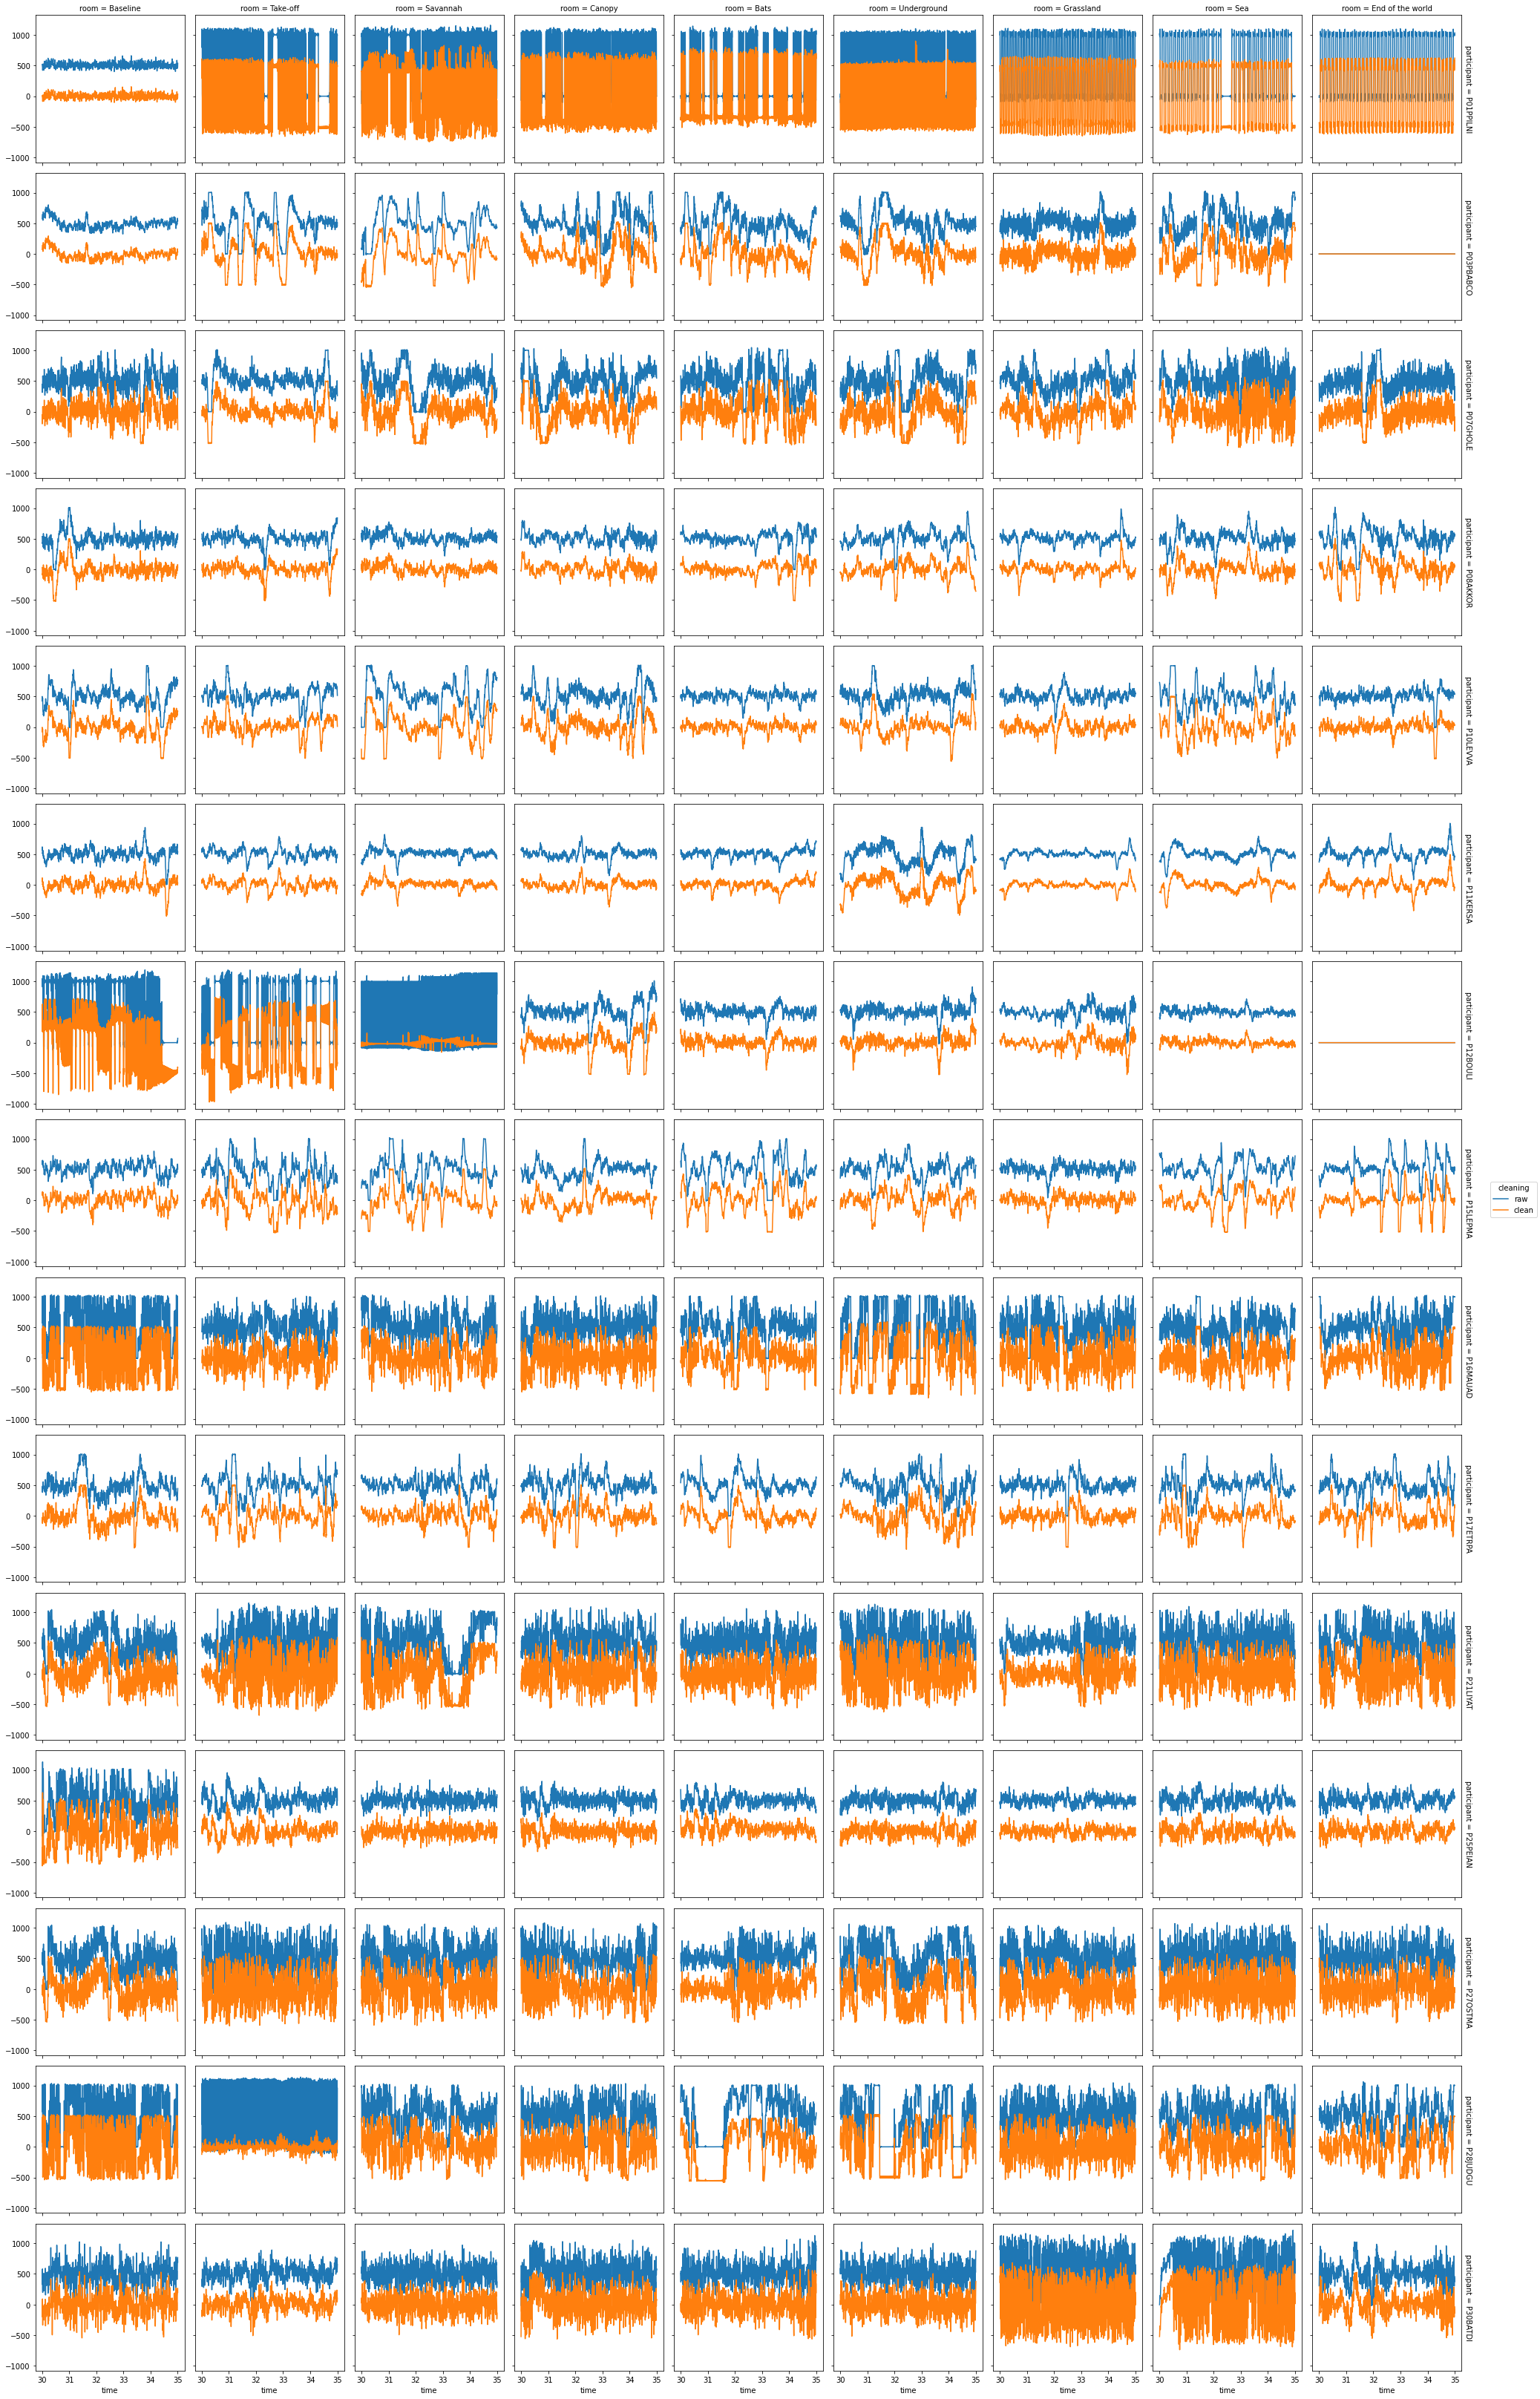

EEGR


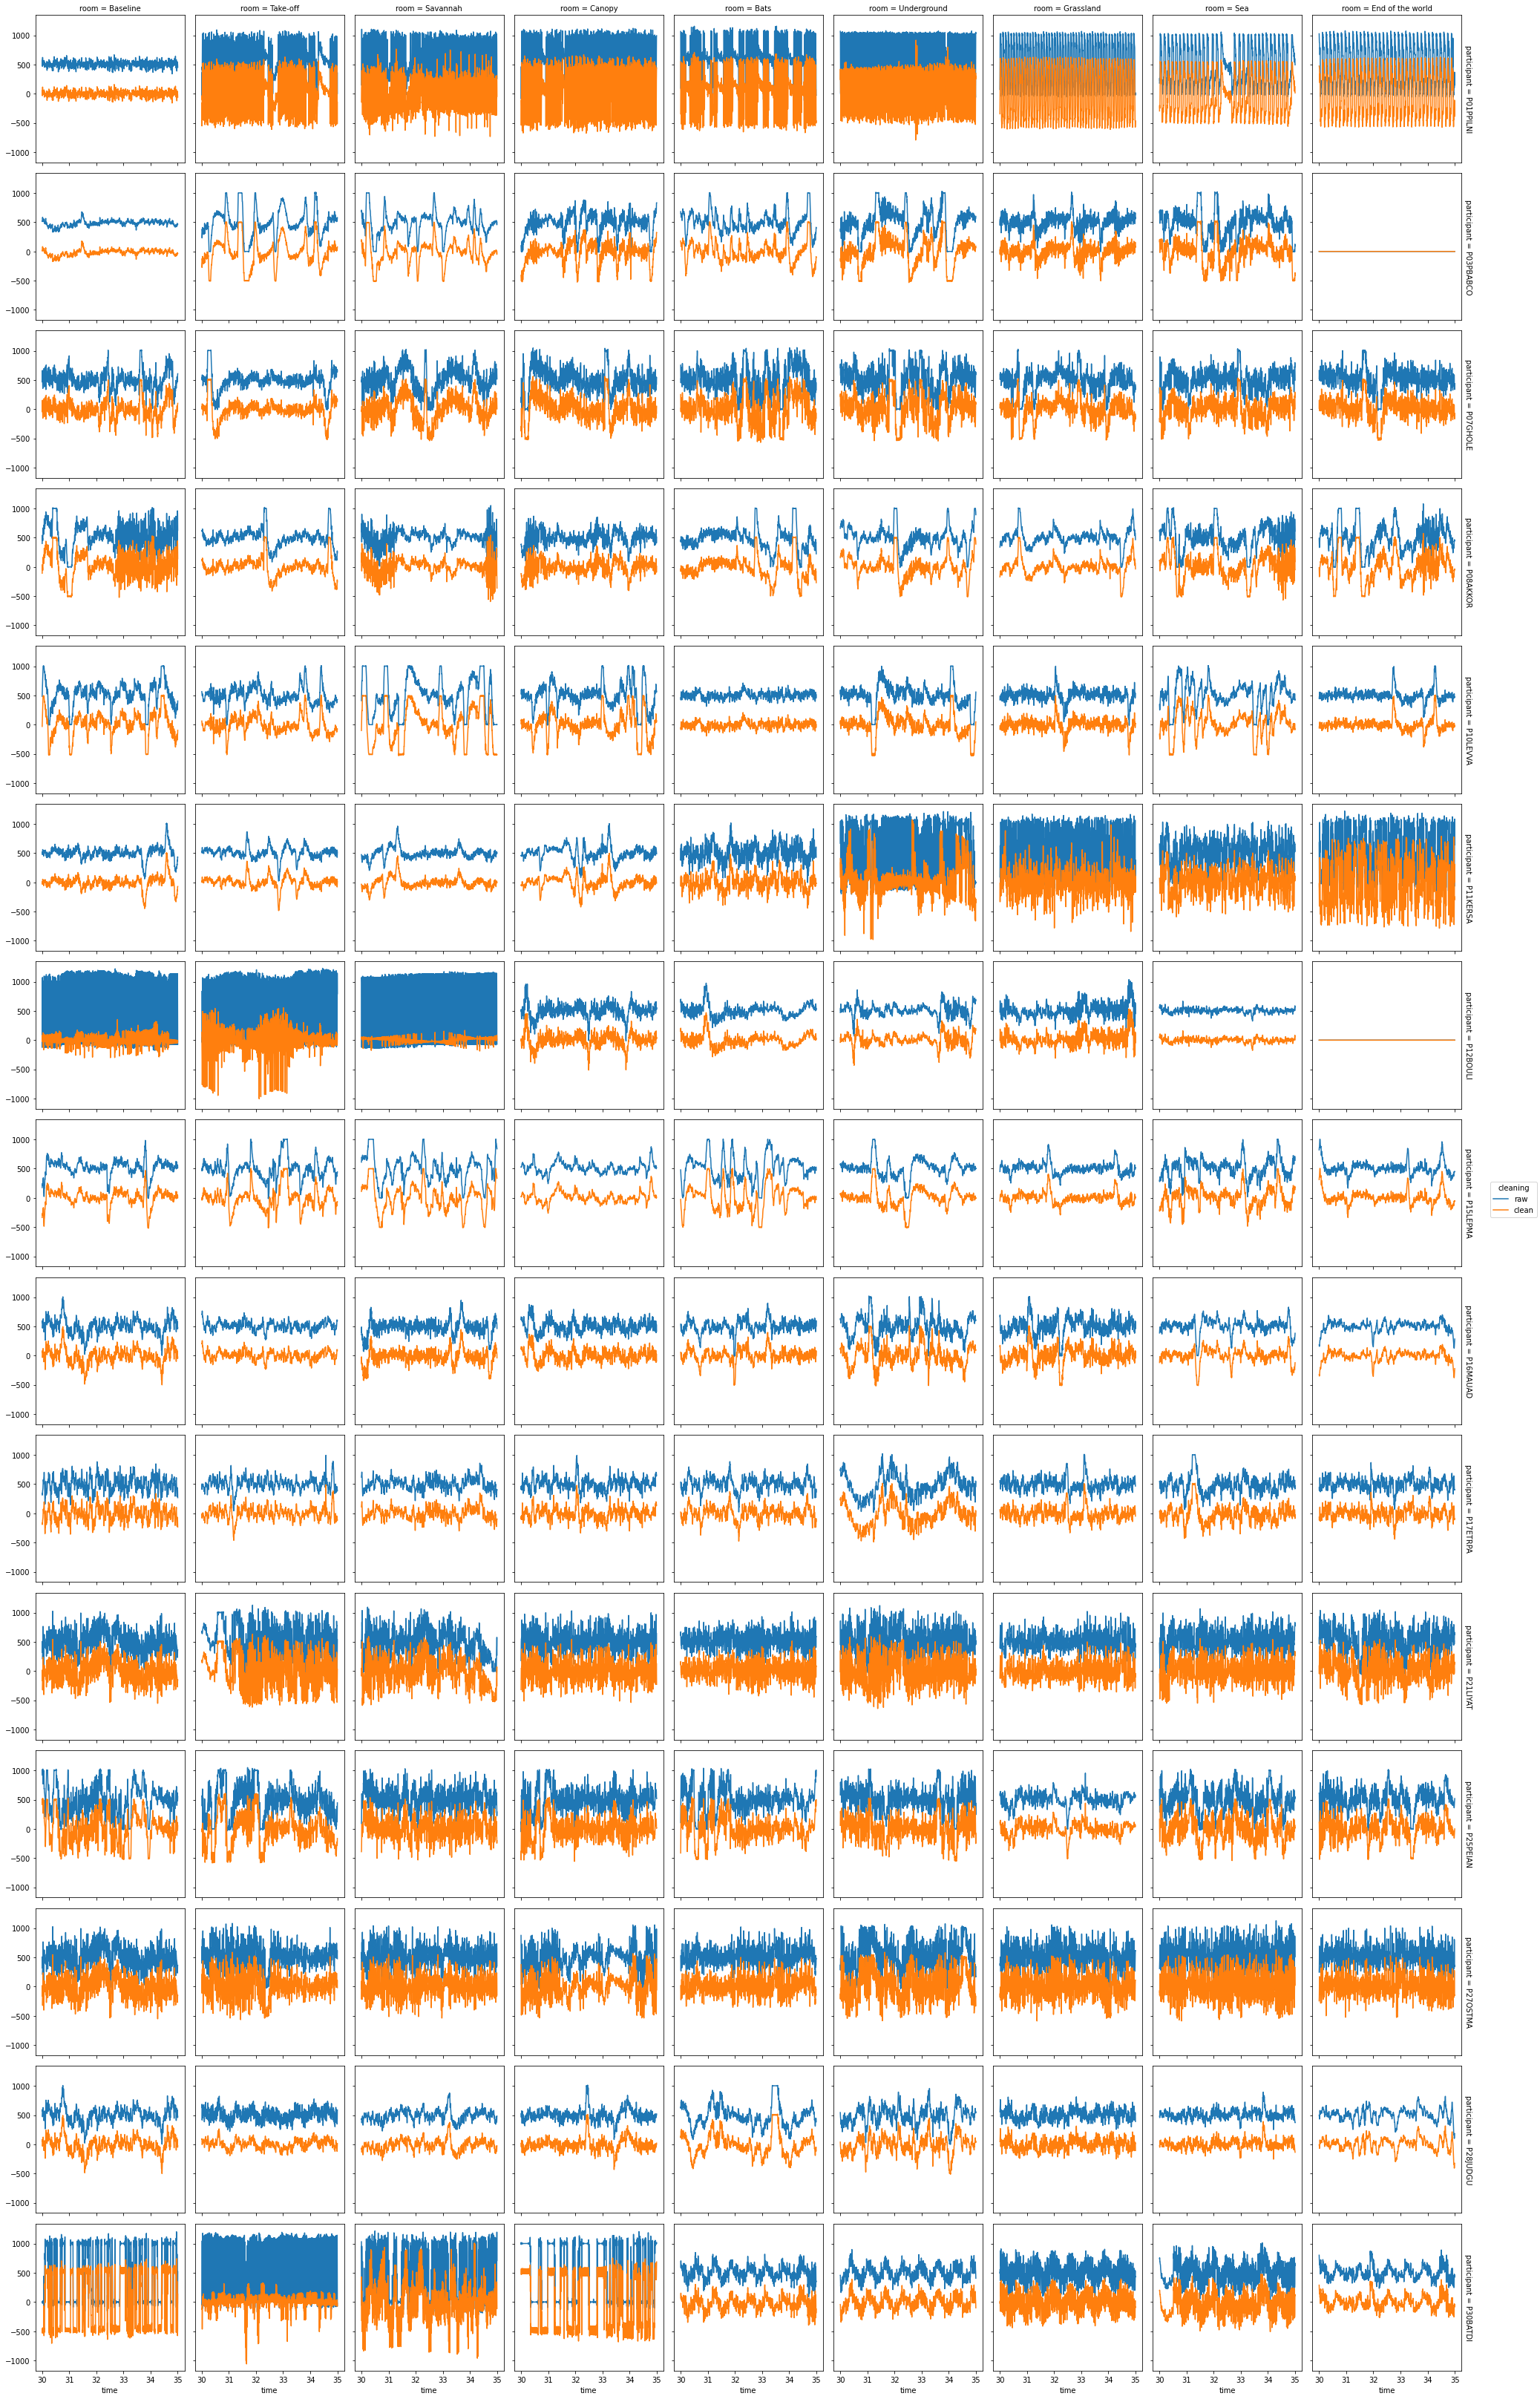

ECG


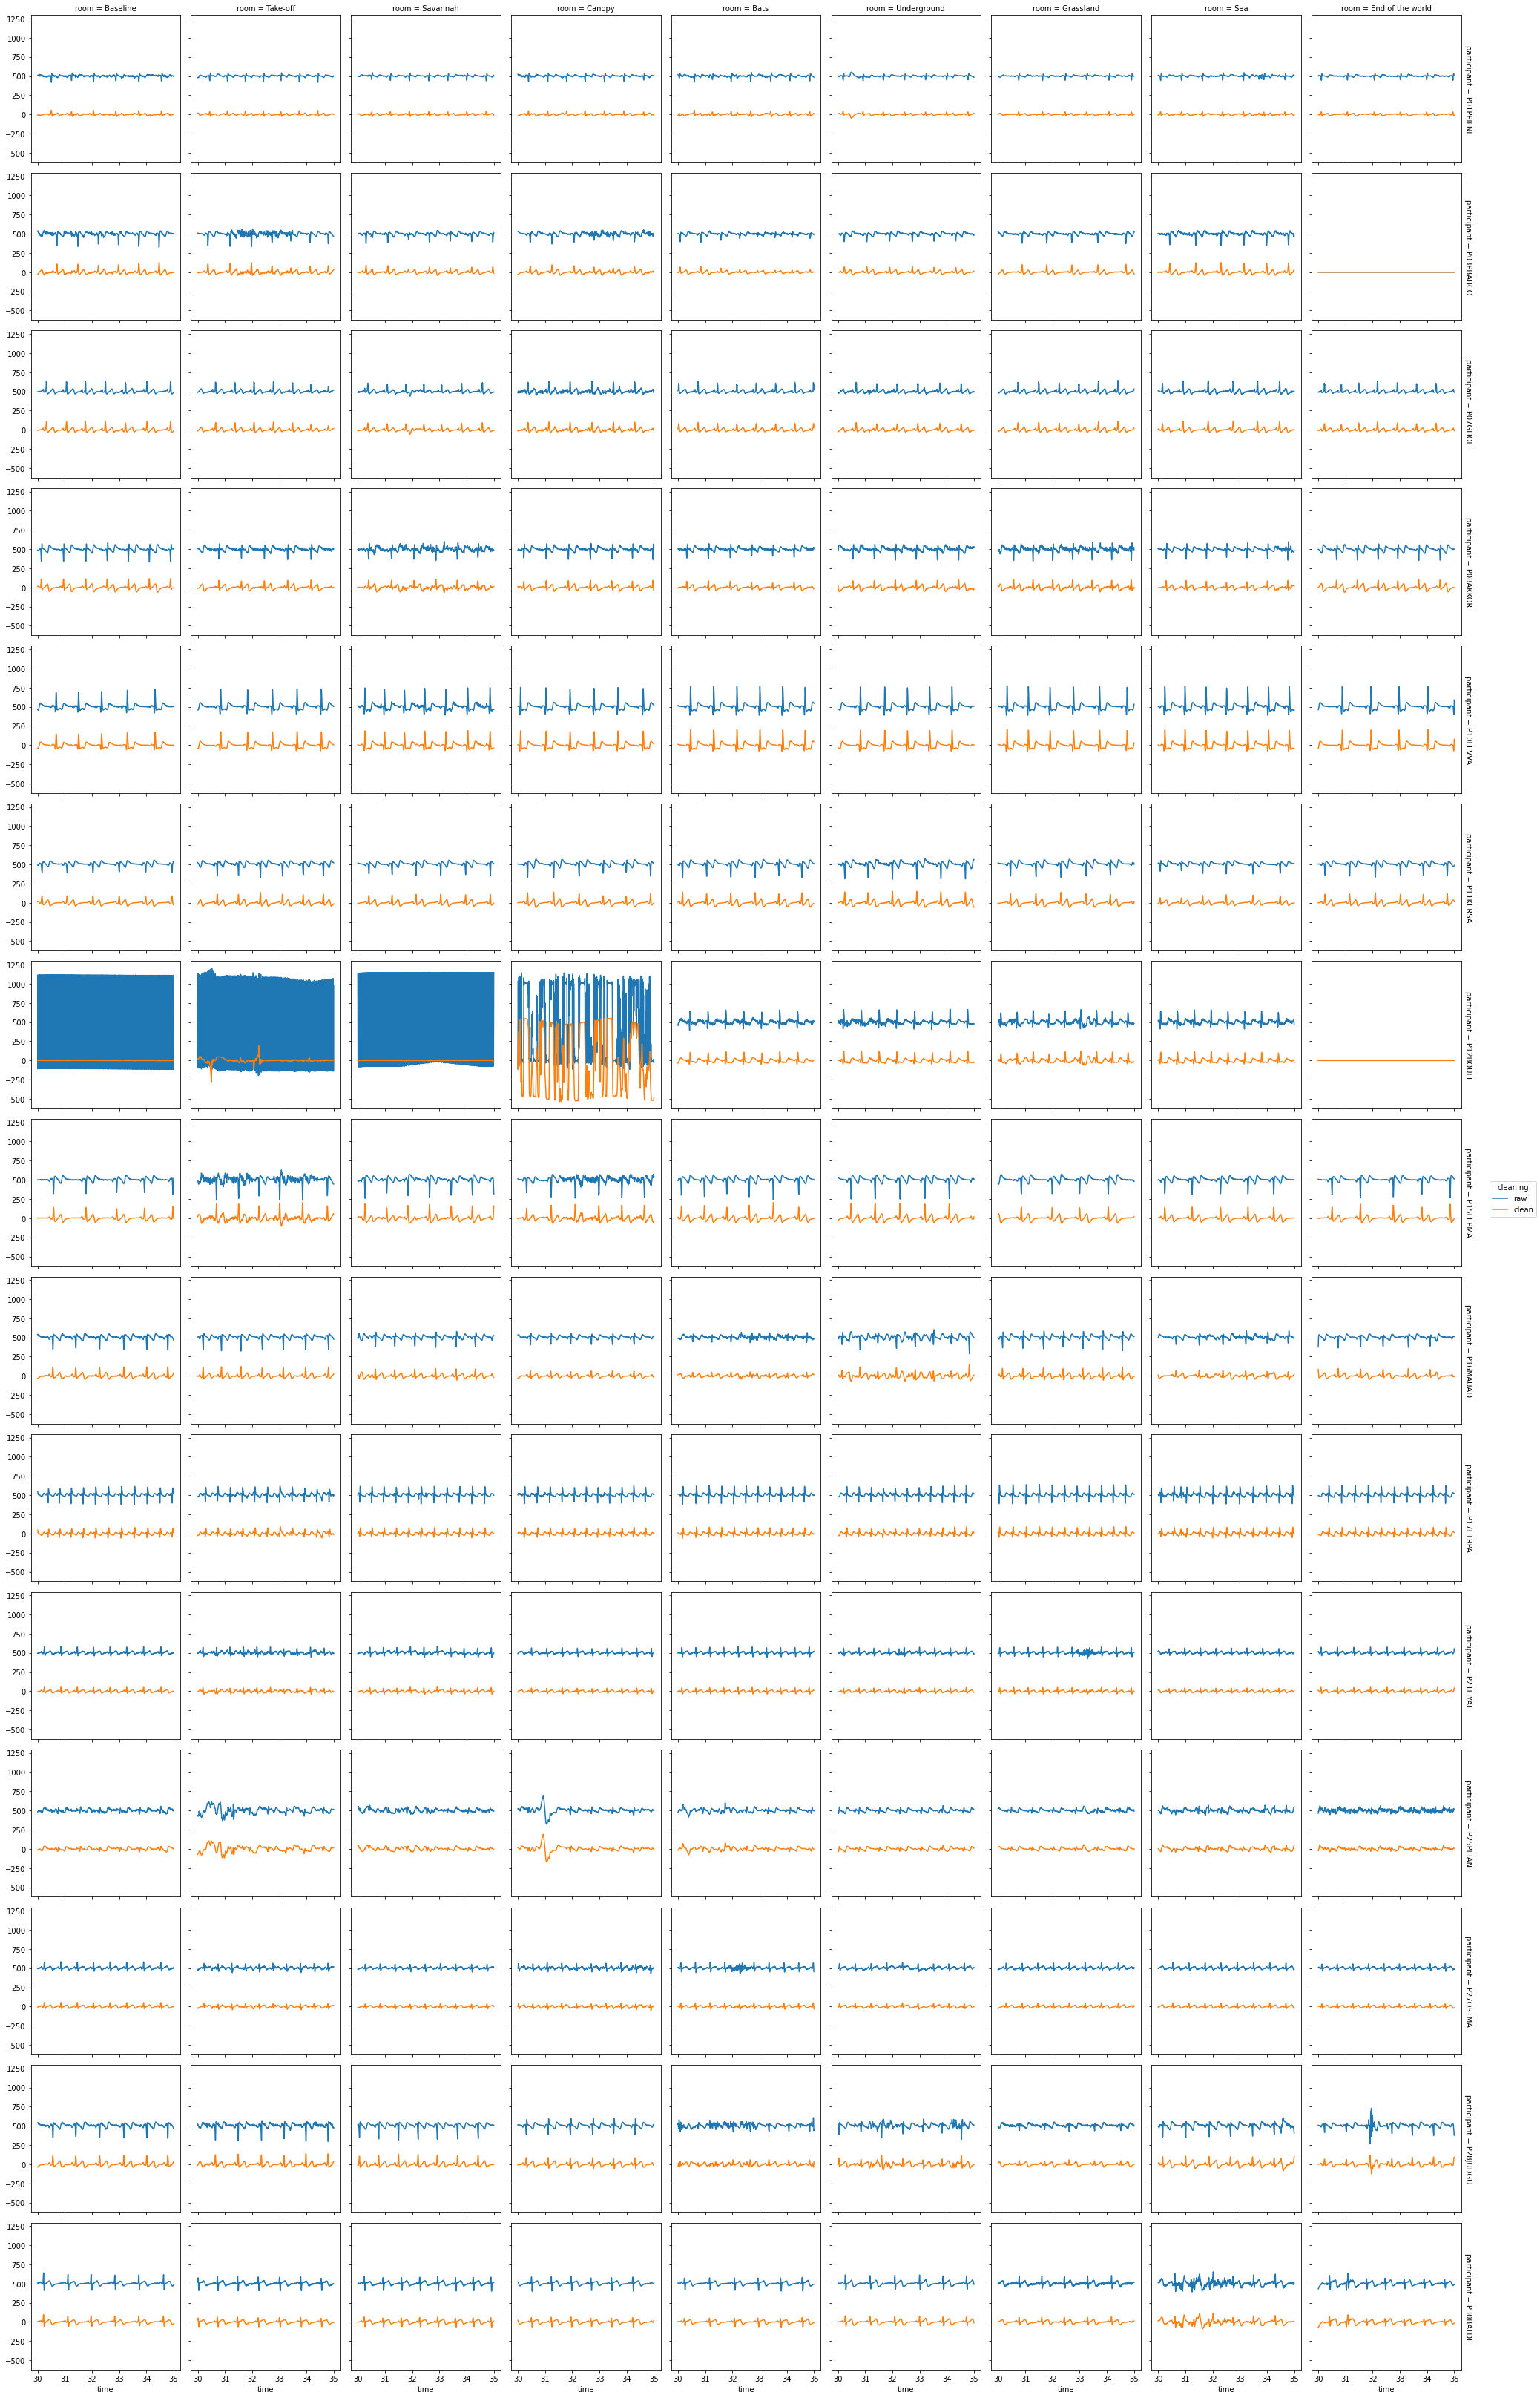

EDA


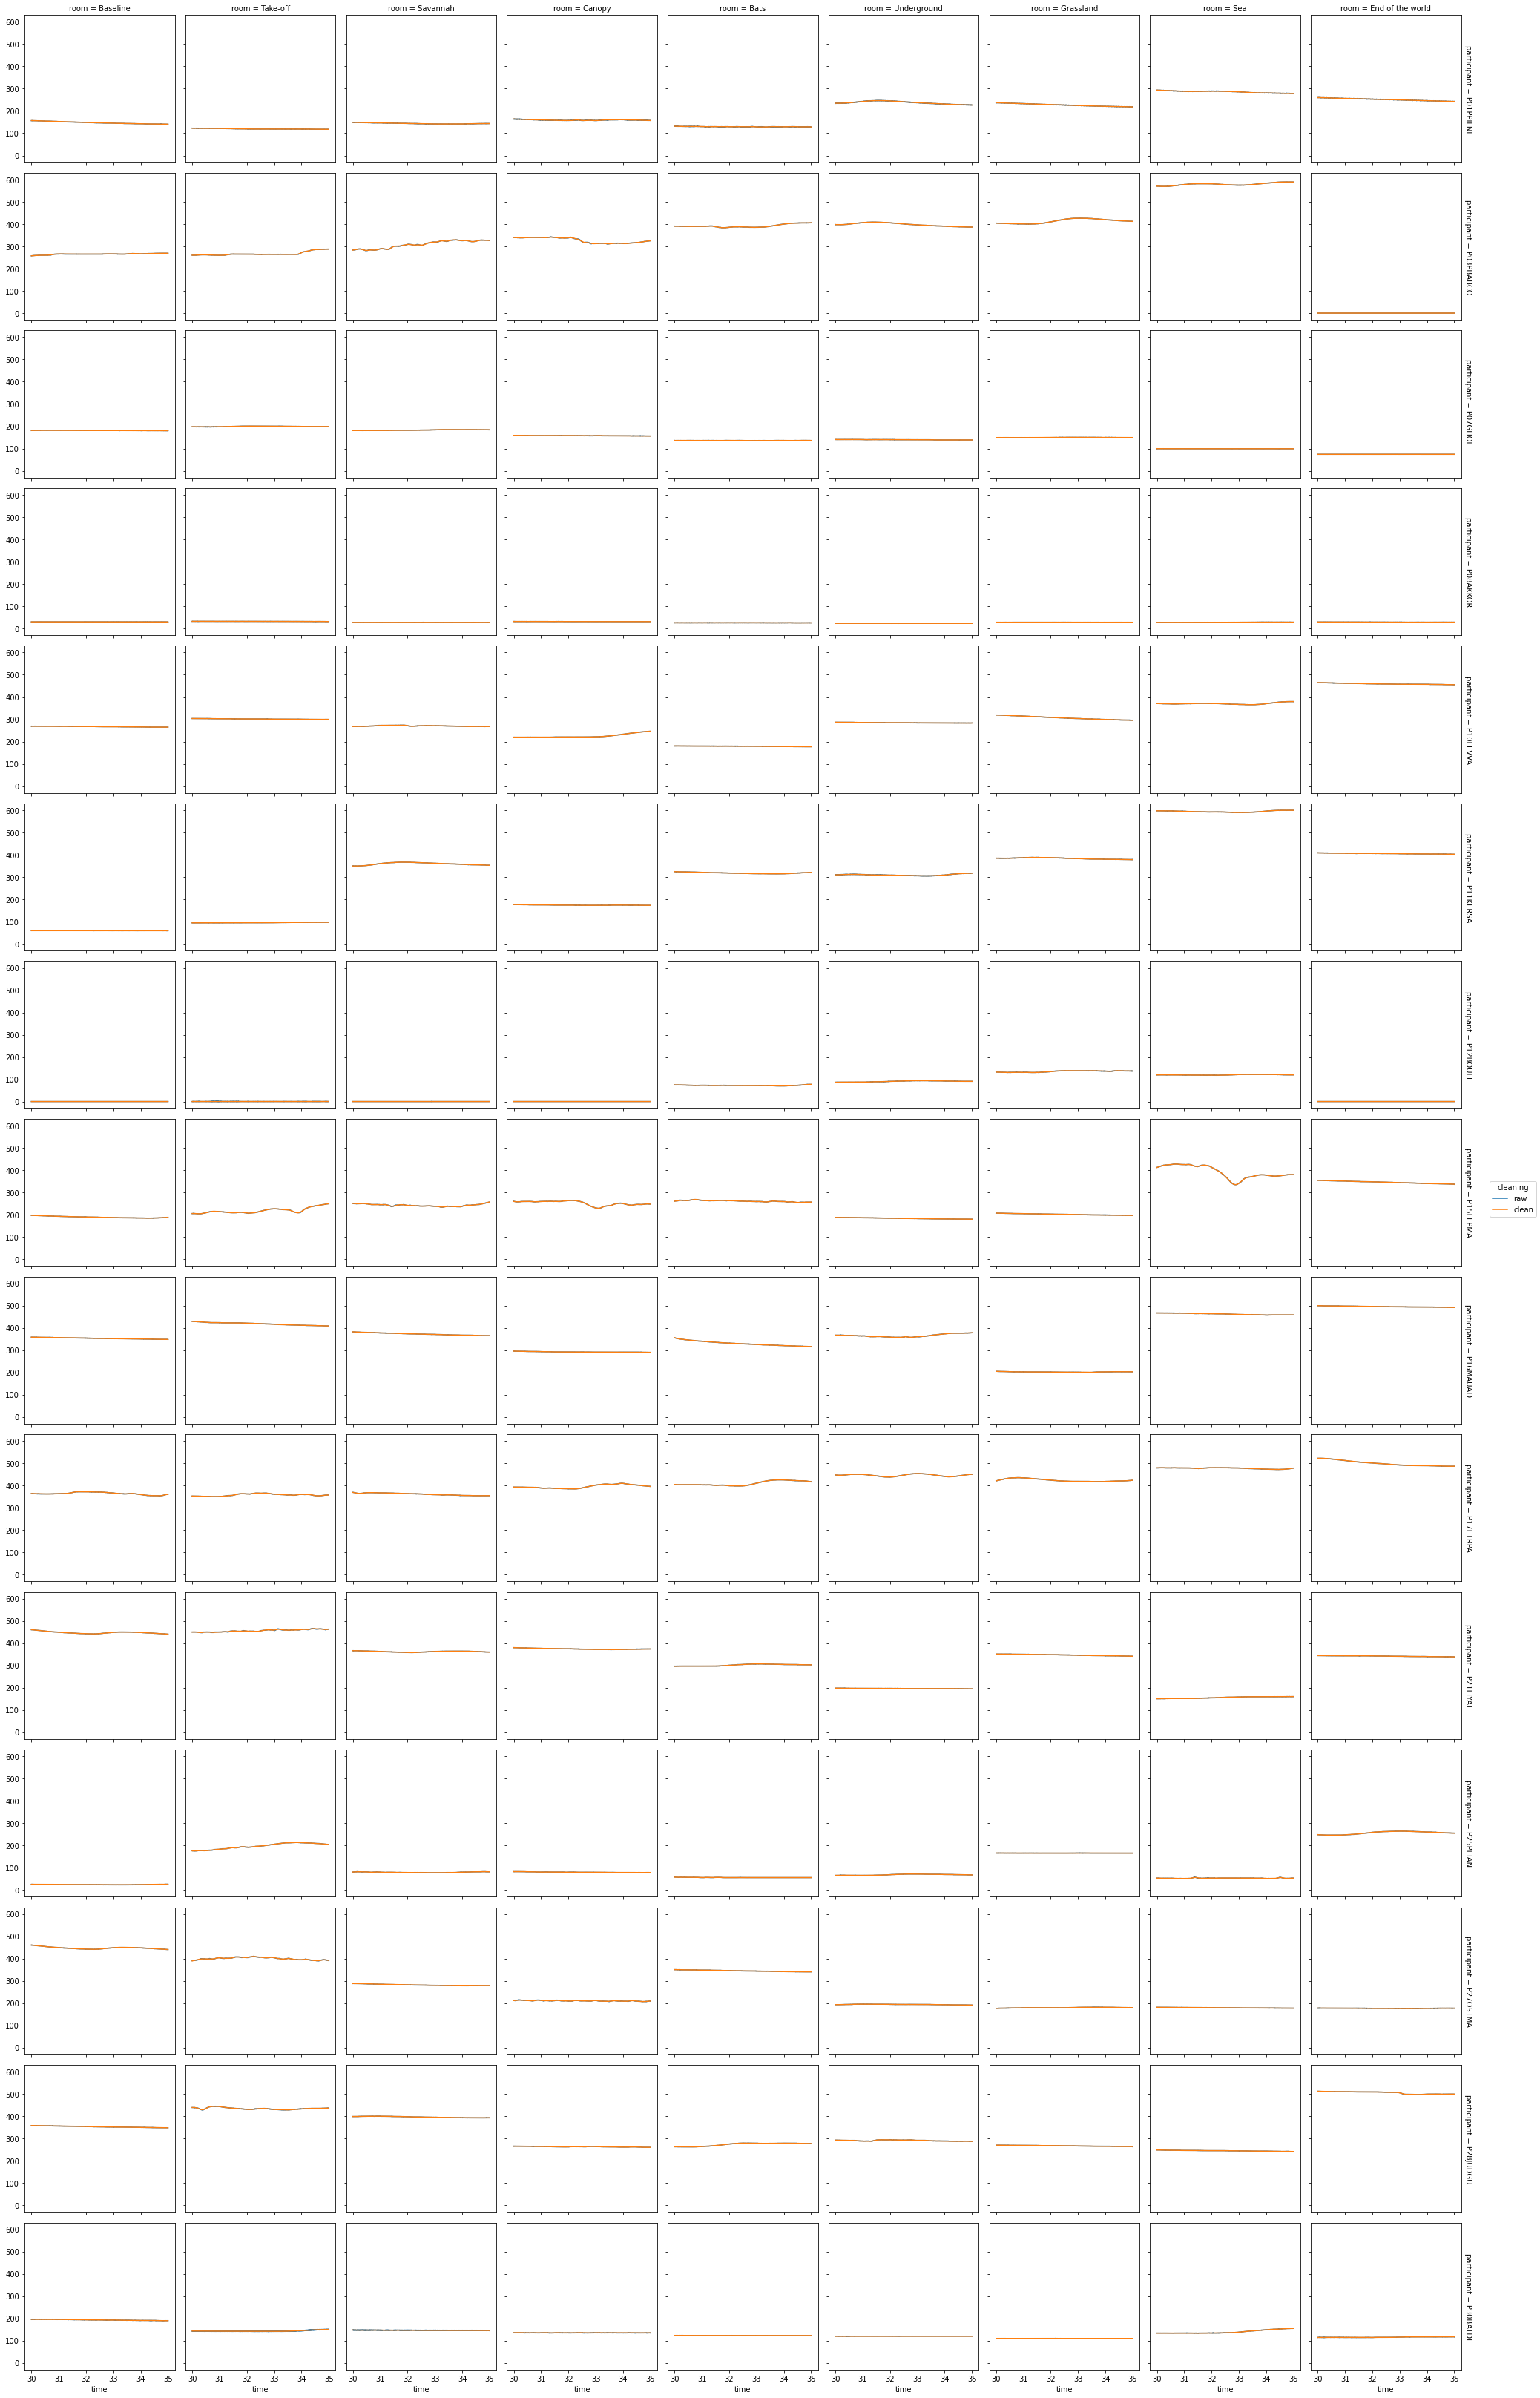

PPG


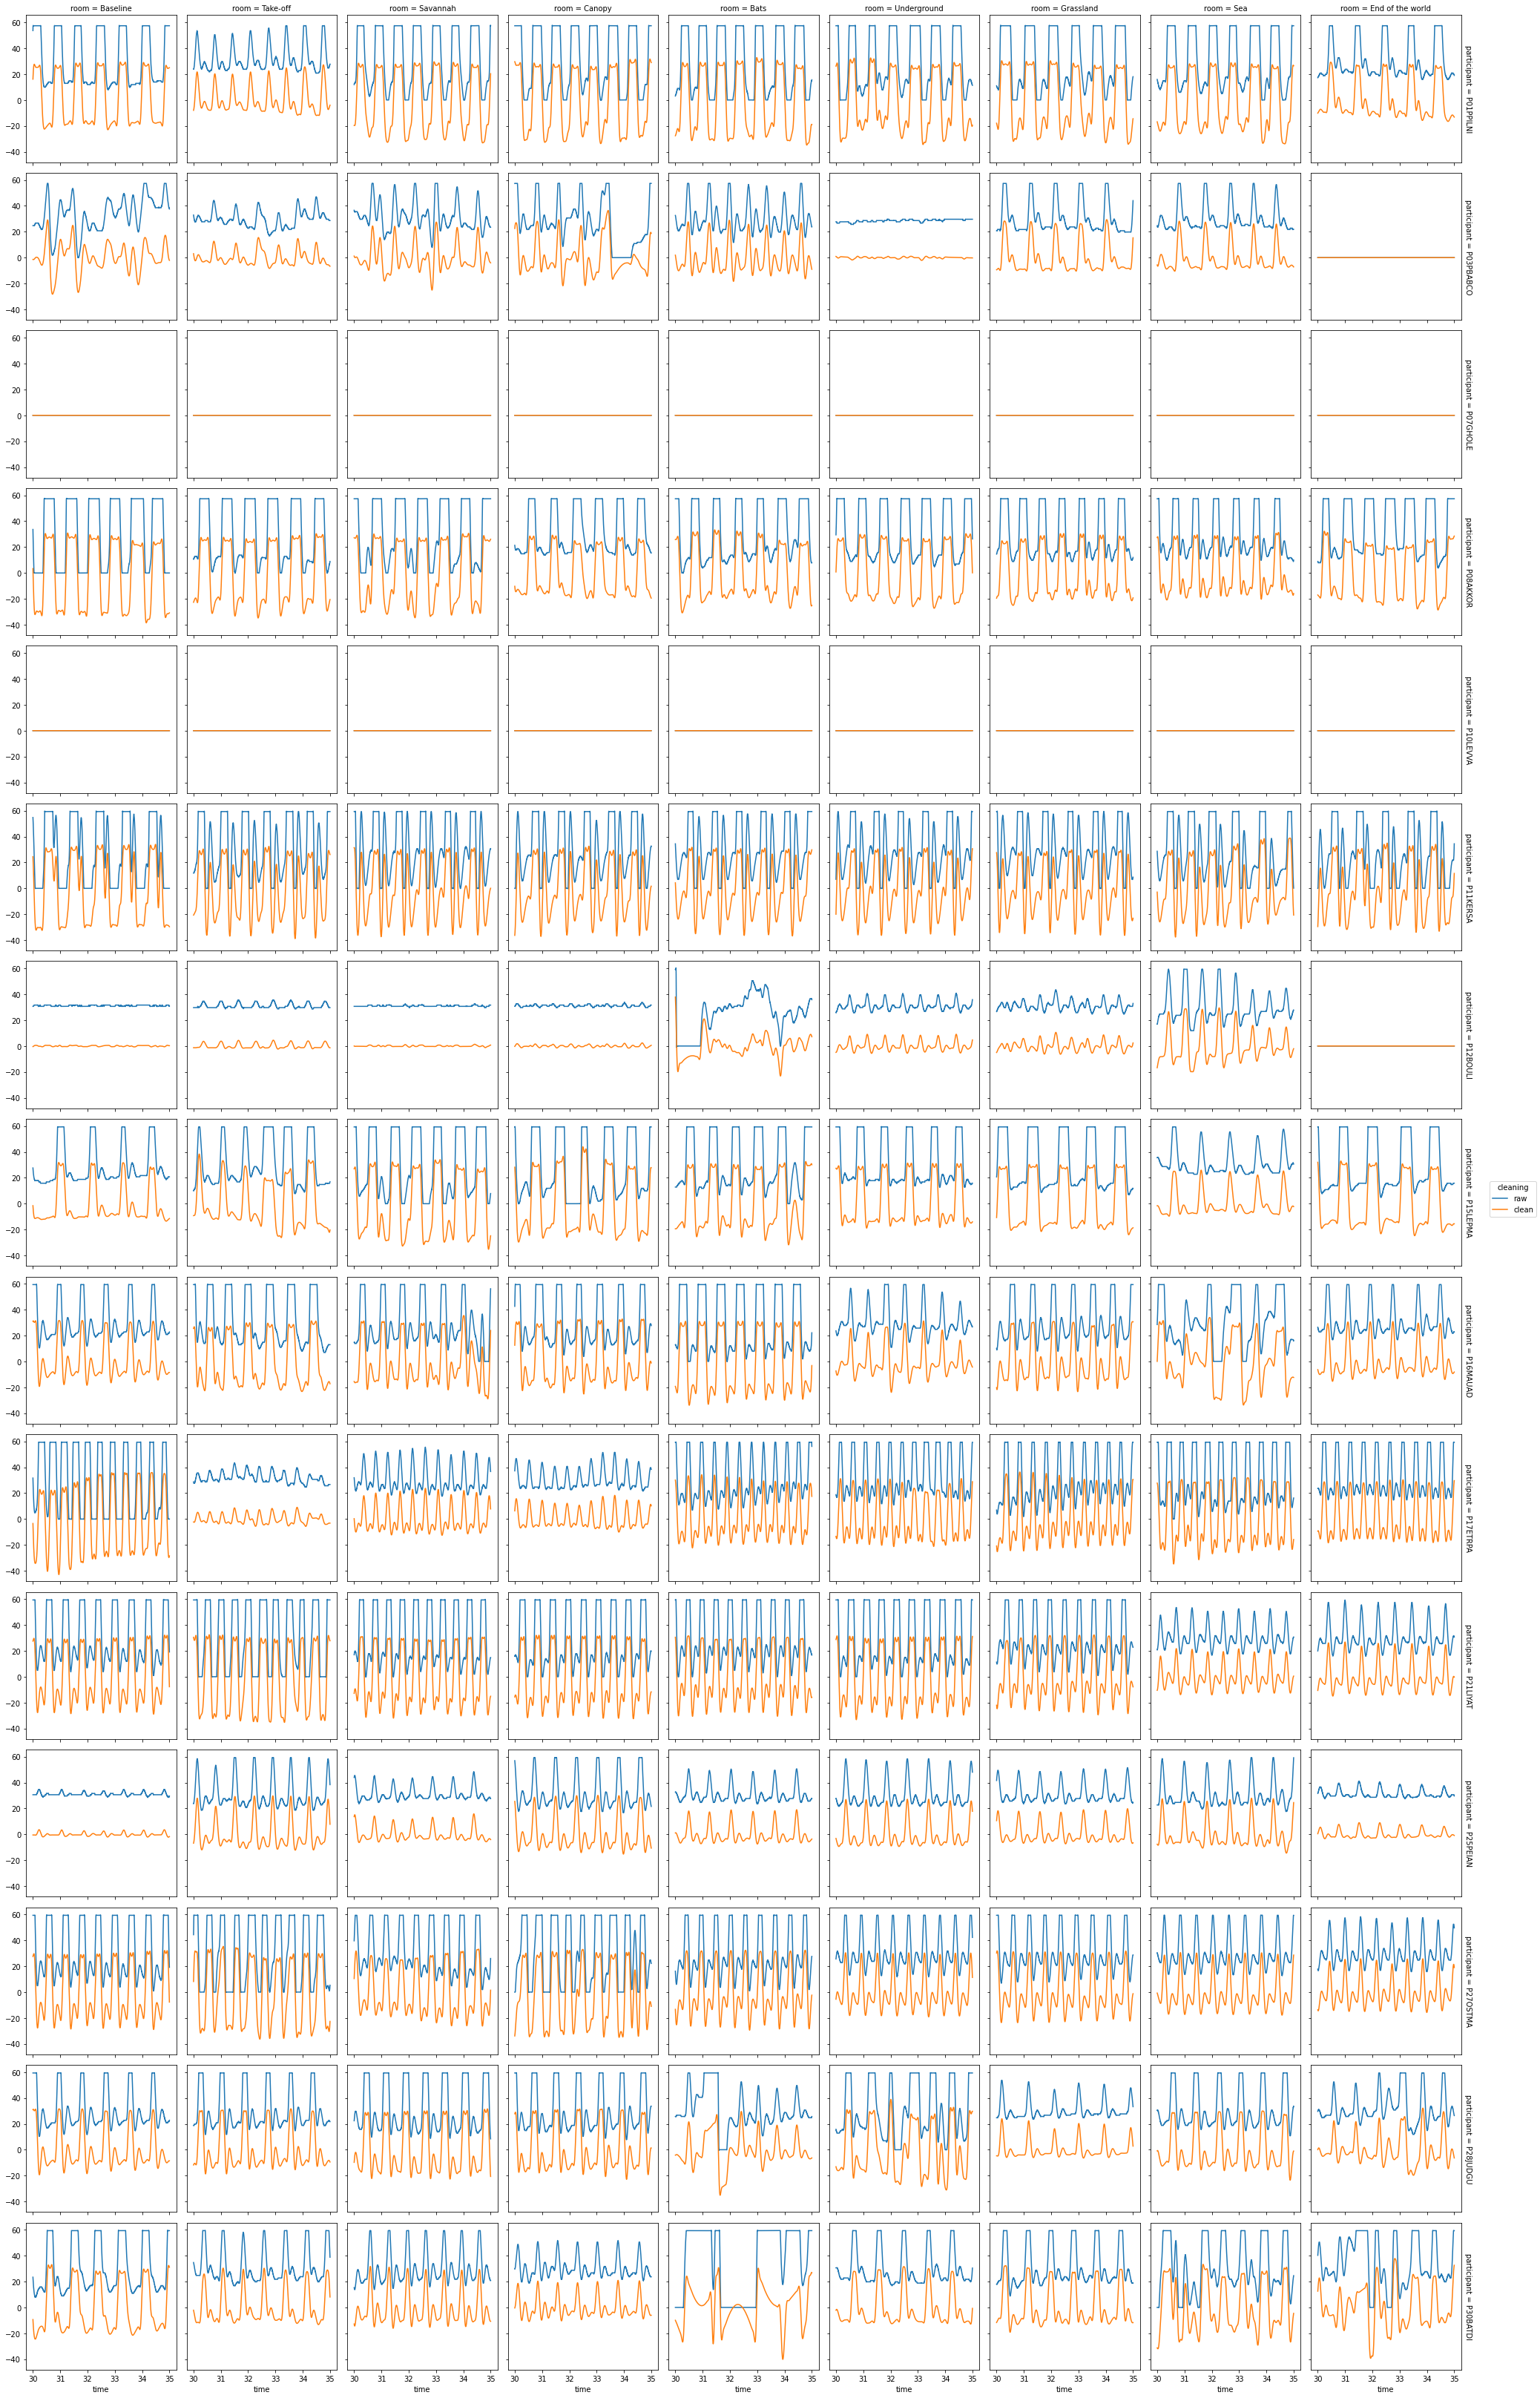

In [33]:
for d in dtypes:
    print(d)
    da_cleaned.sel(dtype = d, time = slice(30,35)).plot.line(x='time',row = 'participant',col = 'room', hue = 'cleaning')
    plt.show()

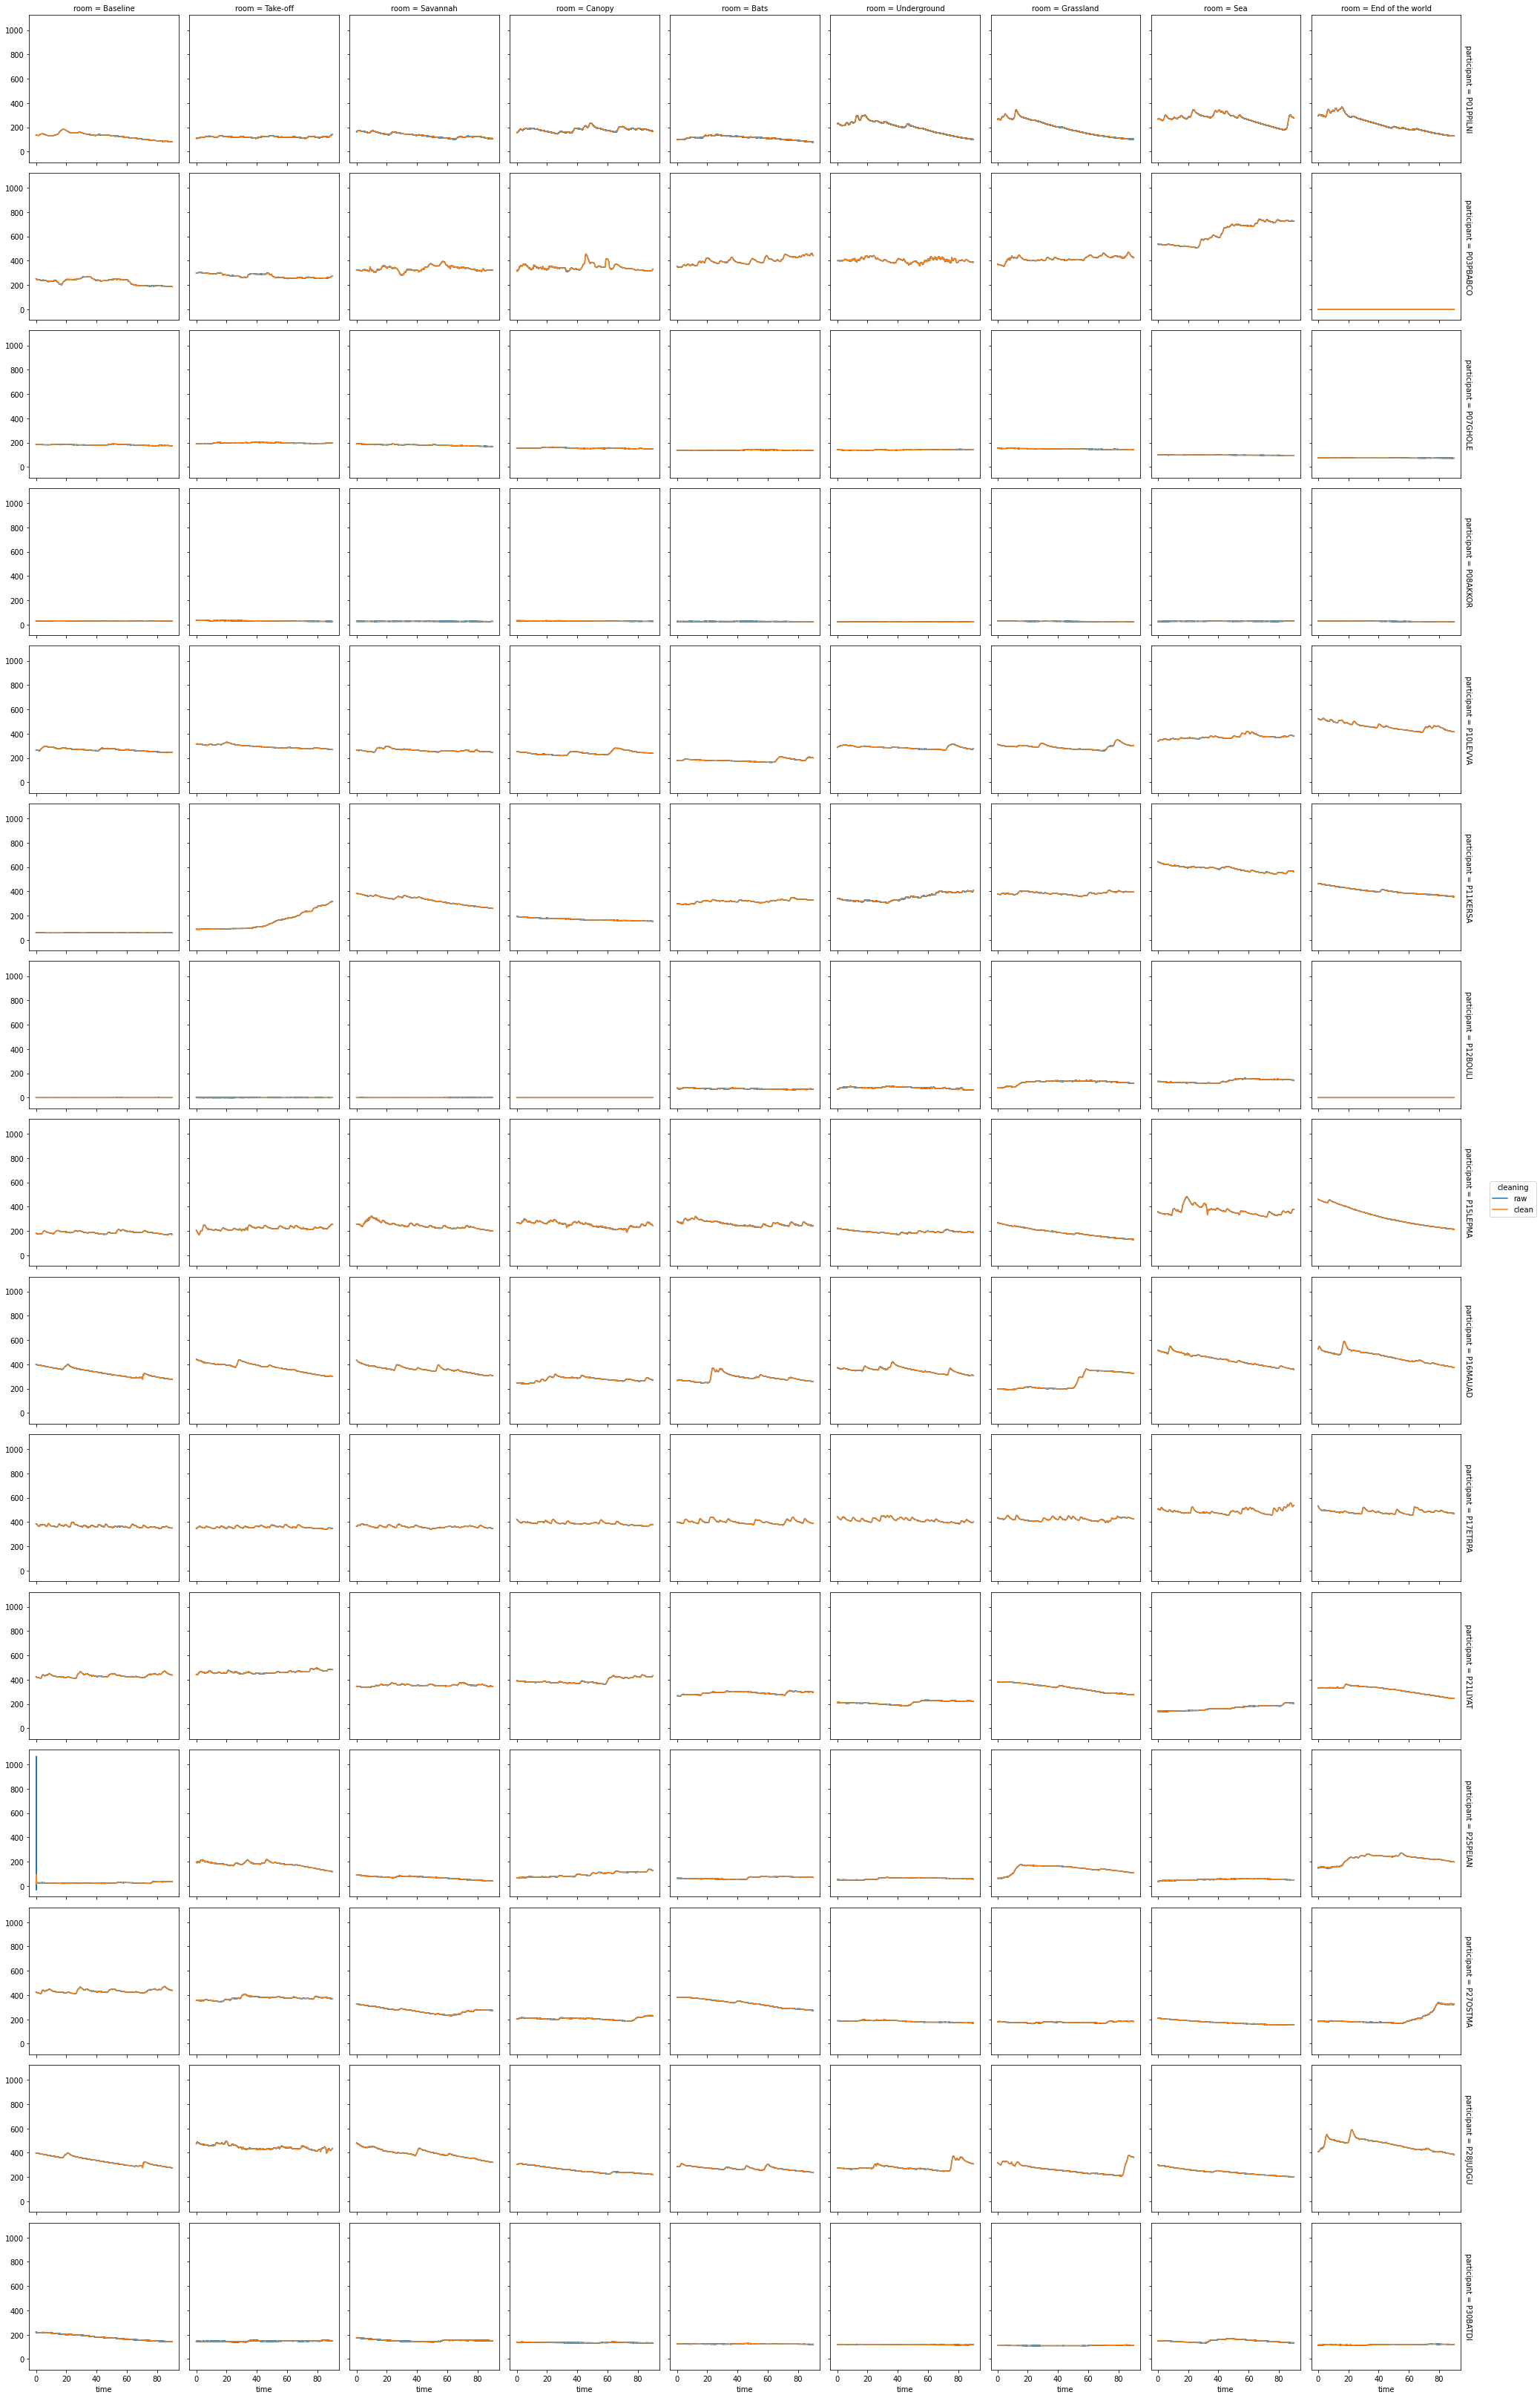

In [34]:
da_cleaned.sel(dtype = 'EDA').plot.line(x='time',row = 'participant',col = 'room', hue = 'cleaning')

In [35]:
quality = pd.read_excel('../data_preprocessed/quality_encoding.xlsx', index_col = 0)
quality.groupby('dtype').mean() # score of quality (visual inspection) by dtype, max = 2, min = 0

quality
dtype          
ECG    0.896552
EDA    0.551724
EEGL   0.379310
EEGR   0.448276
PPG    0.206897